In [1]:
!python -V

Python 3.9.16


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [8]:
df = pd.read_parquet(r'./data/yellow_tripdata_2022-01.parquet')

print(f"There are {df.shape[1]} columns in the dataset")
df.dtypes

There are 19 columns in the dataset


VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [13]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

print(f"The standard deviation of the duration of trips is {df.duration.describe()[2]:.2f} minutes")

The standard deviation of the duration of trips is 46.45 minutes


<Axes: >

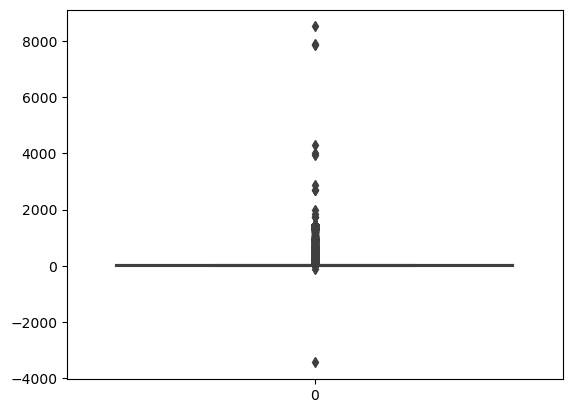

In [33]:
sns.boxplot(df['duration'])

In [16]:
df2 = df[(df.duration >= 1) & (df.duration <= 60)]

print(f"The percentage of data left after removing outliers is {len(df2) * 100/len(df):.2f}%")

The percentage of data left after removing outliers is 98.28%


In [18]:
categorical = ['PULocationID', 'DOLocationID']

df2[categorical] = df2[categorical].astype(str)

C:\Users\ologa\AppData\Local\Temp\ipykernel_8196\776005744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[categorical] = df2[categorical].astype(str)


In [22]:
train_dicts = df2[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print(f" The dimensionality of the matrix is {X_train.shape[0]} rows by {X_train.shape[1]} columns")

 The dimensionality of the matrix is 2421440 rows by 515 columns


In [26]:
target = 'duration'
y_train = df2[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

RMSE = mean_squared_error(y_train, y_pred, squared=False)
print(f"Root mean square of the model is {RMSE:.2f}")

Root mean square of the model is 6.99


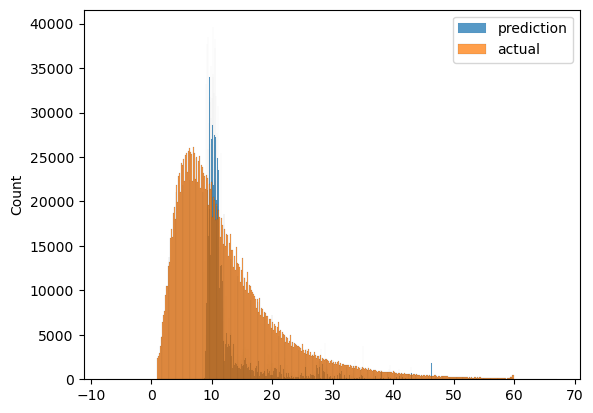

In [25]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

In [29]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)

    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [30]:
df_train = read_dataframe('./data/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2022-02.parquet')

In [31]:
len(df_train), len(df_val)

(2421440, 2918187)

In [32]:
categorical = ['PULocationID', 'DOLocationID']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [34]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

RMSE = mean_squared_error(y_val, y_pred, squared=False)

print(f"Root mean square of the model is {RMSE:.2f}")

Root mean square of the model is 7.79
